$\newcommand{\mr}[1]{\mathrm{#1}}$ 
$\newcommand{\bmr}[1]{\mathit{\mathbf{#1}}}$ 
$\newcommand{\tr}{^\mathrm{T}}$
$\newcommand{\lbr}{\left\lbrace}$
$\newcommand{\rbr}{\right\rbrace}$
$\newcommand{\dd}{\mathrm{d}}$
$\newcommand{\jj}{\mathrm{j}}$

## <center> Pomoćne funkcije
Interaktivni grafici koriste Python modul mpld3, koji se može instalirati komandom
    
    
    conda install mpld3
    
Primeri rade i ukoliko modul mpld3 nije instaliran, ali grafici neće biti interaktivni.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
try:
    import mpld3
    mpld3.enable_notebook()
    print("Modul mpld3 je instaliran.")
except:
    print("Modul mpld3 nije instaliran.")
    
def plotSpectrum(x, xlabel = "", ylabel="", title="", show=True):
    n = len(x)
    plt.plot(np.fft.fftshift(np.fft.fftfreq(n)),np.fft.fftshift(abs(np.fft.fft(x))));
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()
        
def plotSpectrumdB(x, xlabel = "", ylabel="", title="", show=True):
    n = len(x)
    plt.plot(np.fft.fftshift(np.fft.fftfreq(n)),20*np.log10(np.fft.fftshift(abs(np.fft.fft(x)))));
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()
    
def stemSpectrum(x, xlabel = "", ylabel="", title="", show=True):
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x)))
    plt.stem(F, X)#, use_line_collection=True);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()

def plotSignal(x, xlabel = "", ylabel="", title="", show=True):
    plt.plot(x);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()

def stemSignal(x, xlabel = "", ylabel="", title="", show=True):
    plt.stem(x)# ,use_line_collection=True);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()

def genTestSpectrum(n, freq, amp, randPhase=False):
    # Generate test spectrum
    # Arguments:
    #    n    - number of samples
    #    freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
    #    amp  - tuple of amplitudes (ampStart, ampEnd)
    #    randPhase - if True, assign random phase to each sample
    x = np.zeros(n, dtype='complex128')
    freqStart, freqEnd = freq
    ampStart, ampEnd = amp
    indStart = round(n*freqStart)
    indEnd = round(n*freqEnd)
    x[indStart:indEnd] = ampStart - np.linspace(0, 1, num=indEnd-indStart) * (ampStart-ampEnd)
    if randPhase:
        x[indStart:indEnd] *= np.exp(1j*2*np.pi*np.random.rand(indEnd-indStart)) # randomize phase
    x[0] = abs(x[1])/2
    timeDomain = np.fft.ifft(x)
    return(timeDomain)

def compressor(x, D):
    # Downsample the signal by factor D
    #   x - input signal
    #   D - downsampling factor
    return x[0::D]

def expander(x, I):
    # Upsample the signal by factor I
    #   x - input signal
    #   I - upsampling factor
    nx = len(x)
    xI = np.zeros(nx*I)
    xI[::I] = x
    return xI



Modul mpld3 je instaliran.


# <center> Decimacija signala

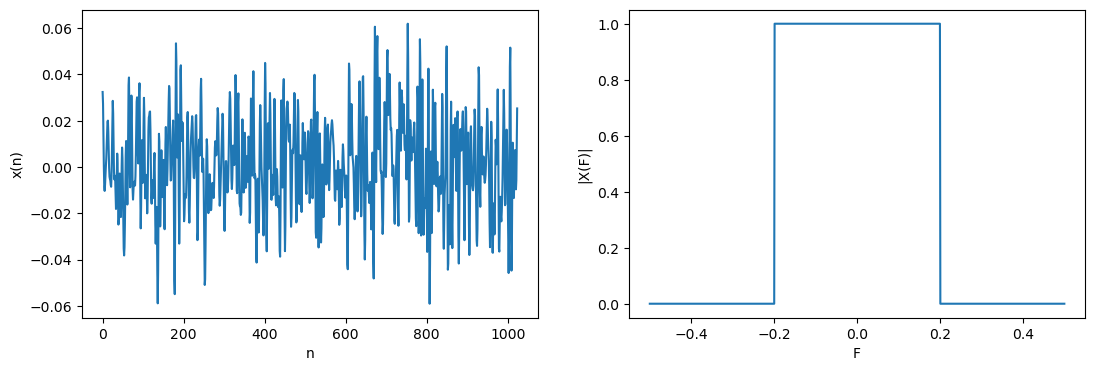

In [2]:
n = 1024
f_max = 0.2
f = [0.0, f_max]
a = [1.0, 1.0]
x = 2*genTestSpectrum(n, f, a, True).real
figH = 4
plt.subplots(1,2,figsize=(2*1.618*figH,figH))
plt.subplot(1,2,1)
plotSignal(x, 'n', 'x(n)', show=False)
plt.subplot(1,2,2)
plotSpectrum(x, 'F', '|X(F)|')

In [3]:
nFIR = 41
D = 4
transitionWidth = 0.05
firResponse = [1.0, 1.0, 0, 0]
firFreqs = [0, 1.0/(2*D)-transitionWidth, 1.0/(2*D), 0.5]
firCoeff = signal.firls(nFIR, firFreqs, firResponse, fs=1)
w, h = signal.freqz(firCoeff)
H = 20*np.log10(abs(h))
plt.plot(w/(2*np.pi), H);
plt.plot([1.0/(2*D)-transitionWidth,1.0/(2*D)-transitionWidth], [np.min(H), 0], 'r--');
plt.plot([1.0/(2*D),1.0/(2*D)], [np.min(H), 0], 'r--');
#plt.ylim(-2,2)

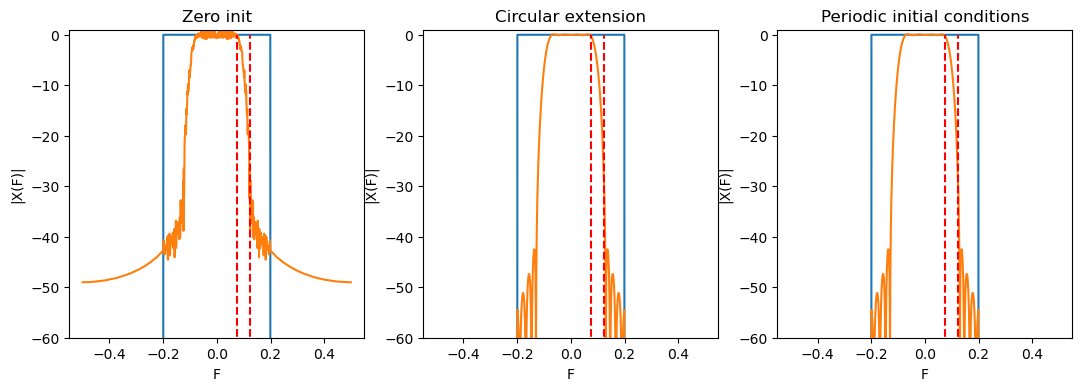

In [5]:
# If initial conditions of FIR filter are all zeros the filtered output is not periodic
# and this leads to spectrum leakage
xlp_zeroinit = signal.lfilter(firCoeff, 1.0, x)
# This can be mitigated by circular extension of input samples
xlp_periodic = signal.lfilter(firCoeff, 1.0, np.concatenate((x,x[0:len(firCoeff)-1])))
xlp_periodic = xlp_periodic[len(firCoeff)-1:]  # discard extra samples
# or by setting the initial condition of FIR filter
tmp, zi = signal.lfilter(firCoeff, 1.0, x, zi=np.zeros(len(firCoeff)-1))
# Now use determined initial conditions
xlp_periodicinit = signal.lfilter(firCoeff, 1.0, x, zi=zi)[0]
# Plot filter output with zero init
figH = 4
plt.subplots(1,3,figsize=(2*1.618*figH,figH))
plt.subplot(1,3,1)
plotSpectrumdB(x, show=False)
plotSpectrumdB(xlp_zeroinit, show=False)
plt.ylim(-60,1)
plt.plot([1.0/(2*D)-transitionWidth,1.0/(2*D)-transitionWidth], [np.min(H), 0], 'r--');
plt.plot([1.0/(2*D),1.0/(2*D)], [np.min(H), 0], 'r--');
plt.xlabel('F'); plt.ylabel('|X(F)|'); plt.title('Zero init');
# Plot filter output for cicrular extension
plt.subplot(1,3,2)
plotSpectrumdB(x, show=False)
plotSpectrumdB(xlp_periodic, show=False)
plt.ylim(-60,1)
plt.plot([1.0/(2*D)-transitionWidth,1.0/(2*D)-transitionWidth], [np.min(H), 0], 'r--');
plt.plot([1.0/(2*D),1.0/(2*D)], [np.min(H), 0], 'r--');
plt.xlabel('F'); plt.ylabel('|X(F)|'); plt.title('Circular extension');
# Plot filter output for initial conditions
plt.subplot(1,3,3)
plotSpectrumdB(x, show=False)
plotSpectrumdB(xlp_periodicinit, show=False)
plt.ylim(-60,1)
plt.plot([1.0/(2*D)-transitionWidth,1.0/(2*D)-transitionWidth], [np.min(H), 0], 'r--');
plt.plot([1.0/(2*D),1.0/(2*D)], [np.min(H), 0], 'r--');
plt.xlabel('F'); plt.ylabel('|X(F)|'); plt.title('Periodic initial conditions');
plt.show()

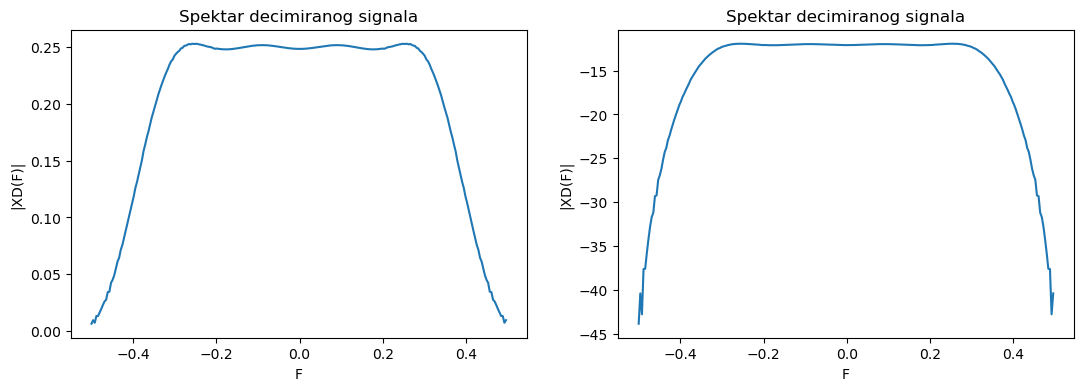

In [6]:
xD = compressor(xlp_periodic, D)
figH = 4
plt.subplots(1,2,figsize=(2*1.618*figH,figH))
plt.subplot(1,2,1)
plotSpectrum(xD, 'F', '|XD(F)|', 'Spektar decimiranog signala', show=False)
plt.subplot(1,2,2)
plotSpectrumdB(xD, 'F', '|XD(F)|', 'Spektar decimiranog signala')

# <center> Interpolacija signala

In [ ]:
n = 1024
f_max = 0.4
f = [0.0, f_max]
a = [1.0, 1.0]
x = 2*genTestSpectrum(n, f, a, True).real
figH = 4
plt.subplots(1,2,figsize=(2*1.618*figH,figH))
plt.subplot(1,2,1)
plotSignal(x, 'n', 'x(n)', show=False)
plt.subplot(1,2,2)
plotSpectrum(x, 'F', '|X(F)|')

In [ ]:
I = 4
xI = expander(x, I)
figH = 7
plt.subplots(2,2,figsize=(1.618*figH,figH))
plt.subplot(2,2,1)
stemSignal(x[0:32], 'n', 'x(n)', 'Signal na fs' , show=False)
plt.subplot(2,2,2)
stemSignal(xI[0:32], 'n', 'xI(n)', 'Signal na I*fs', show=False)
plt.subplot(2,2,3)
plotSpectrum(x, 'F', '|X(F)|', 'Spektar x(n)', show=False)
plt.subplot(2,2,4)
plotSpectrum(xI,"F'", "|XI(F')|", 'Spektar xI(n)', show=False)
plt.tight_layout()
plt.show()

In [ ]:
nFIR = 41
I = 4
firResponse = [I, I, 0, 0] # interpolation filter should have gain I
# Expander maps the spectrum (0, f_max) to (0, f_max/I), so that should be the pass band of FIR filter
# Spectral images are centered at k/I, so the lowest image frequency is 1/I-f_max/I
firFreqs = [0, f_max/I, 1/I-f_max/I, 0.5]
firCoeff = signal.firls(nFIR, firFreqs, firResponse, fs=1)
w, h = signal.freqz(firCoeff)
H = 20*np.log10(abs(h))
plt.plot(w/(2*np.pi), H);
plt.plot([f_max/I,f_max/I], [np.min(H), np.max(H)], 'r--');
plt.plot([1/I-f_max/I,1/I-f_max/I], [np.min(H),  np.max(H)], 'r--');

In [ ]:
# If initial conditions of FIR filter are all zeros the filtered output is not periodic
# and this leads to spectrum leakage
xlp_zeroinit = signal.lfilter(firCoeff, 1.0, x)
# This can be mitigated by circular extension of input samples
xlp_periodic = signal.lfilter(firCoeff, 1.0, np.concatenate((xI,xI[0:len(firCoeff)-1])))
xlp_periodic = xlp_periodic[len(firCoeff)-1:]  # discard extra samples
plotSpectrumdB(xI, show=False)
plotSpectrumdB(xlp_periodic, show=False)
plt.ylim(-90,20*np.log10(I)+5)
plt.plot([f_max/I,f_max/I], [np.min(H), np.max(H)], 'r--');
plt.plot([1/I-f_max/I,1/I-f_max/I], [np.min(H), np.max(H)], 'r--');
plt.xlabel('F'); plt.ylabel('|X(F)|'); plt.title('Circular extension');
plt.show()

# <center> Interpolacija sinusoide

In [ ]:
n = 1024
I = 4
delay = 3
f0 = 32
F0 = f0/n
x = np.sin(2*np.pi*f0*np.arange(0,n)/n)
stemSignal(x[0:32])
xD = compressor(x, I)
stemSignal(xD[0:32])

In [ ]:
xI = expander(xD, I)
stemSignal(xI[0:32])
plotSpectrum(xD, show=False)
plotSpectrum(xI)

In [ ]:
nFIR = 31
firResponse = [I, I, 0, 0] # interpolation filter should have gain I
firFreqs = [0, F0, 1/I-F0, 0.5]
firCoeff = signal.firls(nFIR, firFreqs, firResponse, fs=1)
w, h = signal.freqz(firCoeff)
H = 20*np.log10(abs(h))
plt.plot(w/(2*np.pi), H);
plt.plot([F0,F0], [np.min(H), np.max(H)], 'r--');
plt.plot([1/I-F0,1/I-F0], [np.min(H),  np.max(H)], 'r--');
plotSpectrumdB(xI, show=False)
plt.ylim(-100, 20*np.log10(I)+1)
plt.xlim(0, 0.5)
plt.show()

In [ ]:
xI_lpf = signal.lfilter(firCoeff, 1.0, xI)
xout = compressor(xI_lpf, I)[int((nFIR-1)/2):]
#stemSignal(xout[0:32],show=False)
plt.stem(xout[0:32],markerfmt='o');
offset = 13
tmp = x[offset:]
tmp = tmp[::I]
plt.stem(tmp[0:32],markerfmt='x');
#stemSignal(xD[0:32])